In [111]:
import torch
import emoji
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
sys.path.insert(0, '../')

from tqdm import tqdm
from config import GPT2EmojiConfig
from model import GPT2LMEmojiModel
from transformers import GPT2Tokenizer
from run_language_modeling import load_and_cache_examples, targets_mask
from sst_binary import sst_binary
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


MODEL_CLASSES = {
    "gpt2": (GPT2EmojiConfig, GPT2LMEmojiModel, GPT2Tokenizer),
}

MODEL_PATH = '../checkpoint-180000'

args = torch.load(os.path.join(MODEL_PATH, 'training_args.bin'))

config_class, model_class, tokenizer_class = MODEL_CLASSES['gpt2']

config = config_class.from_pretrained(MODEL_PATH)

tokenizer = tokenizer_class.from_pretrained(MODEL_PATH)

model = model_class.from_pretrained(
            MODEL_PATH,
            config=config,
)

map_target_to_token_id = dict(
        zip(range(0, len(emoji.UNICODE_EMOJI.keys())), tokenizer.encode(list(emoji.UNICODE_EMOJI.keys())))
)

Token indices sequence length is longer than the specified maximum sequence length for this model (2811 > 1024). Running this sequence through the model will result in indexing errors


In [51]:
DATASETS = [
    'Olympic',
    'PsychExp',
    'SCv1',
    'SCv2-GEN',
    'SE0714',
    'SS-Twitter',
    'SS-Youtube',
]
DIR = '../data'
FILENAME_RAW = 'raw.pickle'
CLASSES = 'joy, fear, anger, sadness, disgust, shame, guilt'.split(', ')

In [34]:
def load_dataset(dataset):
    print(dataset)
    DATASET_PATH = f'{DIR}/{dataset}/{FILENAME_RAW}'
    with open(DATASET_PATH, 'rb') as file:
        data = pickle.load(file, fix_imports=True, encoding='bytes')
    
    # Decode data
    texts = [str(x) for x in data[b'texts']]
    # Extract labels
    labels = [x[b'label'] for x in data[b'info']]
    return texts, labels

def decode(y_in):
    y_out = []
    for y in y_in:
        y_out.append(np.argmax(y))
    return y_out

def tokenize(X, tokenizer, block_size=512):
    return tokenizer.batch_encode_plus(X, add_special_tokens=True, max_length=block_size)["input_ids"]

def predict_mean(X_ids, model):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_id = logits.mean(dim=0).argmax().item()
        token_id = map_target_to_token_id[target_id]
        token = tokenizer.decode(token_id)
        
        preds.append(token)
    return preds

def predict_last(X_ids, model):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_id = logits[-1].argmax().item()
        token_id = map_target_to_token_id[target_id]
        token = tokenizer.decode(token_id)
        
        preds.append(token)
    return preds

def predict_max(X_ids, model):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_id = logits.max(0)[0].argmax().item()
        token_id = map_target_to_token_id[target_id]
        token = tokenizer.decode(token_id)
        
        preds.append(token)
    return preds

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [28]:
X, y = load_dataset(DATASETS[1])
y = decode(y)

PsychExp


In [33]:
Xt = tokenize(X, tokenizer)

In [35]:
mean_preds = predict_mean(Xt, model)

100%|██████████| 7480/7480 [10:01<00:00, 12.43it/s]


In [36]:
last_preds = predict_last(Xt, model)

100%|██████████| 7480/7480 [09:45<00:00, 12.78it/s]


In [37]:
max_preds = predict_max(Xt, model)

100%|██████████| 7480/7480 [09:26<00:00, 13.21it/s]


In [39]:
mean_cm = pd.crosstab(pd.Series(mean_preds), pd.Series(y))
mean_cm

col_0,0,1,2,3,4,5,6
row_0,,,,,,,
✅,1,0,0,0,0,0,0
✨,1,3,0,1,0,0,0
❤,6,0,0,2,0,0,0
🌊,4,3,0,0,0,2,0
🌞,2,0,0,0,0,0,0
🌱,1,0,0,0,0,0,0
🎂,5,0,0,0,0,0,0
🎉,1,0,0,0,0,0,0
🎶,1,3,0,1,0,0,0


In [50]:
last_cm = pd.crosstab(pd.Series(last_preds), pd.Series(y))
last_cm

,oy,fear,anger,sadness,disgust,shame,guilt
row_0,,,,,,,
✊,0,0,0,0,0,1,0
✨,5,3,0,0,0,1,0
❤,39,3,2,12,4,3,6
➡,1,0,0,0,1,0,0
🌊,3,8,1,0,0,3,0
...,...,...,...,...,...,...,...
🙃,16,48,40,14,17,35,51
🙄,1,9,62,9,68,18,10
🙏,22,7,2,7,9,4,6


In [41]:
max_cm = pd.crosstab(pd.Series(max_preds), pd.Series(y))
max_cm

col_0,0,1,2,3,4,5,6
row_0,,,,,,,
☕,0,0,1,0,0,0,0
✅,21,1,7,3,0,5,1
✊,1,0,0,0,0,0,0
✨,3,1,0,1,0,0,0
❤,4,0,0,4,0,0,2
...,...,...,...,...,...,...,...
🙃,0,2,3,1,1,0,4
🙄,0,0,2,0,2,1,1
🙏,9,2,2,3,1,3,8


In [42]:
cramers_corrected_stat(mean_cm.to_numpy())

0.1620271991210835

In [43]:
cramers_corrected_stat(last_cm.to_numpy())

0.2782614044650746

In [44]:
cramers_corrected_stat(max_cm.to_numpy())

0.19819516470490542

In [52]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    last_cm.columns = CLASSES
    display(last_cm)

,joy,fear,anger,sadness,disgust,shame,guilt
row_0,,,,,,,
✊,0,0,0,0,0,1,0
✨,5,3,0,0,0,1,0
❤,39,3,2,12,4,3,6
➡,1,0,0,0,1,0,0
🌊,3,8,1,0,0,3,0
🌕,0,1,0,0,0,0,0
🌞,2,0,0,0,0,0,0
🌻,0,0,0,1,0,0,0
🍀,1,0,0,0,0,0,0


In [53]:
def predict_topk_last(X_ids, model, k=5):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_ids = logits[-1].topk(k)[1].tolist()
        token_ids = [map_target_to_token_id[target_id] for target_id in target_ids]
        tokens = tokenizer.decode(token_ids)
        
        preds.append(tokens.split())
    return preds

In [55]:
last_preds_2 = predict_topk_last(Xt, model, k=2)

df = pd.DataFrame(last_preds_2)

last_cm_2 = pd.crosstab([df[col] for col in df.columns], pd.Series(y))

cramers_corrected_stat(last_cm_2.to_numpy())

100%|██████████| 7480/7480 [16:03<00:00,  7.76it/s] 


0.3193758887839968

In [56]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    last_cm_2.columns = CLASSES
    display(last_cm_2)

joy  fear  anger  sadness  disgust  shame  guilt
0 1                                                  
✊ 👍    0     0      0        0        0      1      0
✨ ❤    3     0      0        0        0      0      0
  🎶    0     2      0        0        0      0      0
  💙    1     0      0        0        0      0      0
  🖤    0     1      0        0        0      0      0
  😉    0     0      0        0        0      1      0
  🙏    1     0      0        0        0      0      0
❤ ✨    1     0      0        0        0      0      0
  🎶    0     0      0        0        1      0      0
  💔    0     0      0        1        0      0      2
  💕   14     0      0        1        1      0      2
  💙    5     2      0        3        0      0      0
  💛    1     0      0        0        0      0      0
  💜    2     0      0        0        0      0      0
  😂    3     0      0        1        0      1      1
  😊   10     1      0        1        0      0      0
  😍    1     0      0        0        0      0      0
  😔    0     0      1        0        0      1      1
  😢    0     0      0        1        0      0      0
  😭    1     0      1        1        1      0      0
  🙃    0     0      0        2        0      0      0
  🙏    1     0      0        1        1      1      0
➡ 👇    1     0      0        0        0      0      0
  😂    0     0      0        0        1      0      0
🌊 🎶    1     1      0        0        0      0      0
  💔    0     1      0        0        0      0      0
  💙    1     1      0        0        0      0      0
  😁    0     1      0        0        0      0      0
  😂    0     2      0        0        0      1      0
  😊    1     0      0        0        0      0      0
  😍    0     0      0        0        0      2      0
  😱    0     1      1        0        0      0      0
  🙃    0     1      0        0        0      0      0
🌕 🌙    0     1      0        0        0      0      0
🌞 😁    1     0      0        0        0      0      0
  😊    1     0      0        0        0      0      0
🌻 😭    0     0      0        1        0      0      0
🍀 🏆    1     0      0        0        0      0      0
🍕 😂    1     0      0        0        0      0      0
🍷 🍹    0     0      0        0        1      0      0
  🍺    0     0      0        0        0      2      0
🍹 🍺    0     1      0        0        0      0      0
🍺 🍻    1     0      0        0        0      1      0
  😂    0     0      0        0        1      3      0
🍻 🍹    1     0      0        0        0      0      0
  🍺    2     0      0        0        0      0      0
🎂 🎉    2     0      0        0        0      0      0
  💐    1     0      0        0        0      0      0
  💕    2     0      0        0        0      0      0
  😂    0     0      0        0        0      1      0
  😊    4     0      0        0        0      0      1
  🙂    0     0      0        0        0      0      1
🎉 😊    1     0      0        0        0      0      0
🎥 📸    0     1      0        0        0      0      0
  😂    0     0      0        0        1      0      0
🎶 ✨    0     1      0        0        0      0      0
  ❤    0     0      0        1        0      0      0
  🎧    1     0      0        0        0      0      0
  💙    1     2      0        0        0      0      0
  📸    0     1      0        0        0      0      0
  😁    0     1      0        0        0      0      0
  😂    0     2      0        0        0      0      0
  😉    0     0      0        0        0      0      1
  😊    0     1      0        1        0      0      1
  😍    0     0      0        0        1      0      0
  😔    0     1      0        0        0      0      0
  😭    0     0      0        0        0      1      0
  🙃    0     3      0        2        0      0      1
🏀 🏈    4     1      0        0        0      0      0
  👇    0     0      1        0        0      0      0
  💪    1     0      0        0        0      0      0
  🔥    2     0      0        0        0      0      0
  😂    1 

In [71]:
#Entropy
def entropy(Y):
    """
    Also known as Shanon Entropy
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

#Joint Entropy
def joint_entropy(Y,X):
    """
    H(Y;X)
    Reference: https://en.wikipedia.org/wiki/Joint_entropy
    """
    YX = np.c_[Y,X]
    return entropy(YX)

#Conditional Entropy
def conditional_entropy(Y, X):
    """
    conditional entropy = Joint Entropy - Entropy of X
    H(Y|X) = H(Y;X) - H(X)
    Reference: https://en.wikipedia.org/wiki/Conditional_entropy
    """
    return joint_entropy(Y, X) - entropy(X)

#Uncertainty Coefficient
def theil_u(X, Y):
    """
    Reference: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    """
    h_X = entropy(X)
    h_XY = conditional_entropy(X, Y)
    return (h_X - h_XY) / h_X 

In [75]:
theil_u(y, mean_preds)

0.037195174700355535

In [74]:
theil_u(y, last_preds)

0.1013919044129799

In [76]:
theil_u(y, max_preds)

0.06354520831589082

In [77]:
theil_u(y, last_preds_2)

0.18320203031311752

In [78]:
last_preds_3 = predict_topk_last(Xt, model, k=3)
theil_u(y, last_preds_3)

100%|██████████| 7480/7480 [14:30<00:00,  8.59it/s]


0.3136941606546896

## Logreg

In [115]:
from sklearn.metrics import f1_score
def train_with_reg_cv(trX, trY, vaX, vaY, teX=None, teY=None, penalty='l1',
        C=2**np.arange(-8, 1).astype(np.float), seed=42, solver='liblinear', max_iter=int(1e6), metrics='score'):
    scores = []
    for i, c in enumerate(C):
        model = LogisticRegression(C=c, penalty=penalty, random_state=seed+i, solver=solver, max_iter=max_iter)
        model.fit(trX, trY)
        if metrics == 'f1':
            y_pred = model.predict(vaX)
            score = f1_score(vaY, y_pred, average='macro')
        else:
            score = model.score(vaX, vaY)
        scores.append(score)
    c = C[np.argmax(scores)]
    model = LogisticRegression(C=c, penalty=penalty, random_state=seed+len(C), solver=solver, max_iter=max_iter)
    model.fit(trX, trY)
    
    return model, c, scores

def transform_last(X, model, tokenizer, args):
    X_ids = tokenize(X, tokenizer, args.block_size)
    probas = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        probas.append(logits[-1].tolist())
    return probas

def transform_mean(X, model, tokenizer, args):
    X_ids = tokenize(X, tokenizer, args.block_size)
    probas = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        probas.append(logits.mean(0).tolist())
    return probas

def transform_max(X, model, tokenizer, args):
    X_ids = tokenize(X, tokenizer, args.block_size)
    probas = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        probas.append(logits.max(0)[0].tolist())
    return probas

In [112]:
Xtrans_last = transform_last(X, model, tokenizer, args)

100%|██████████| 7480/7480 [18:11<00:00,  6.86it/s]  


In [113]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_last, y, train_size=1000, random_state=42)

In [116]:
train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')

(LogisticRegression(C=0.03125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.03125,
 [0.49908100782288817,
  0.5103934867829333,
  0.5147157372864913,
  0.519669233265277,
  0.5191977815859214,
  0.51452614719557,
  0.5057256848020322,
  0.4962433776937846,
  0.4888026079341595])

In [102]:
Xtrans_mean = transform_mean(X, model, tokenizer, args)

100%|██████████| 7480/7480 [15:21<00:00,  8.12it/s]


In [103]:
Xtrans_max = transform_max(X, model, tokenizer, args)

100%|██████████| 7480/7480 [18:00<00:00,  6.92it/s]


In [104]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_mean, y, train_size=1000, random_state=42)

In [105]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.125,
 [0.46435185185185185,
  0.47824074074074074,
  0.49027777777777776,
  0.49583333333333335,
  0.5015432098765432,
  0.5032407407407408,
  0.5010802469135802,
  0.4959876543209877,
  0.48595679012345677])

In [106]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_max, y, train_size=1000, random_state=42)

In [107]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.015625, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.015625,
 [0.42962962962962964,
  0.4368827160493827,
  0.44351851851851853,
  0.44243827160493826,
  0.43549382716049384,
  0.42824074074074076,
  0.42314814814814816,
  0.4162037037037037,
  0.4115740740740741])

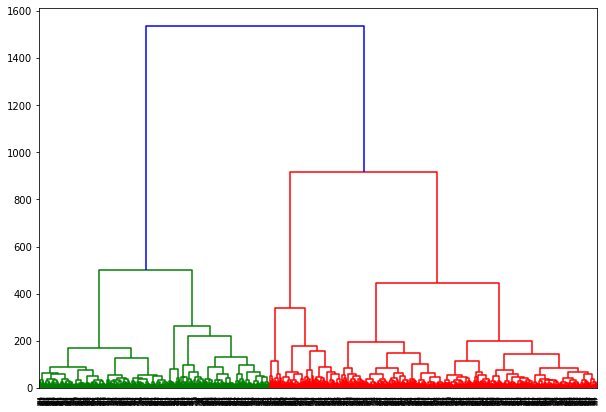

In [80]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(trXtrans, method='ward'))